In [24]:
# This is only needed if the notebook is run in VSCode
import nbs_pipeline.utils.vscode  as vs
vs.DisplayHandle.update = vs.update_patch

In [25]:
try:
    from tsai.all import *
except:
    from tsai.all import * # TODO: Weird error when loading tsai!from tchub.all import *
import wandb
wandb_api = wandb.Api()
from fastcore.all import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.schedule import *
from dvats.all import *
import nbs.orelm_torch as orelm
import nbs_pipeline.utils.config as cfg


In [26]:
#Import Configuration
config, job_type, dataSet = cfg.get_artifact_config_ORELM(True)

Current: /home/macu/work/nbs_pipeline
yml: ./config/02c-encoder_orelm.yaml
... About to replace includes with content
Before configuration reading 
-include: None
-user_preferences:
	-use_wandb: False
	-wdb:
		-user: mi-santamaria
		-project_name: test-project
		-version: 0
		-mode: offline
		-artifacts_path: ./data/wandb_artifacts
	-data:
		-folder: ~/data/
		-fname: Semantic_Segmentation_TiltABP
		-ftype: .csv
		-cols: []
		-freq: 1s
	-artifact:
		-alias: TiltABP
	-directories:
		-tmp: tmp
		-data: ~/data/Semantic_Segmentation_TiltABP.csv
-data:
	-name: Semantic_Segmentation_TiltABP
	-path: ~/data/Semantic_Segmentation_TiltABP.csv
	-alias: TiltABP
	-cols: []
	-csv_config:
	-date_offset: None
	-date_format: %Y-%m-%d %H:%M:%S
	-freq: 1s
	-joining_train_test: False
	-missing_values:
		-technique: None
		-constant: None
	-normalize_training: False
	-range_training: None
	-range_testing: None
	-resampling_freq: None
	-start_date: None
	-test_split: None
	-time_col: None
-wandb:
	-user: mi

In [27]:
dataSet = 'speed_6005'
filePath = '~/data/'+dataSet+'.csv'
print(filePath)
df = pd.read_csv(filePath, header=0, skiprows=[], names=['timestamp', 'data'])
#df = pd.read_csv(filePath, header=1, skiprows=[], names=['timestamp', 'data'])
df.head(5)
print(df['data'])

~/data/speed_6005.csv
0       90
1       80
2       84
3       94
4       90
        ..
2495    81
2496    89
2497    87
2498    82
2499    83
Name: data, Length: 2500, dtype: int64


In [28]:
df.info()
print(df['data'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  2500 non-null   object
 1   data       2500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.2+ KB
0       90
1       80
2       84
3       94
4       90
        ..
2495    81
2496    89
2497    87
2498    82
2499    83
Name: data, Length: 2500, dtype: int64


In [29]:
df.isnull().sum()
print(df['data'])

0       90
1       80
2       84
3       94
4       90
        ..
2495    81
2496    89
2497    87
2498    82
2499    83
Name: data, Length: 2500, dtype: int64


In [30]:
# standardize data by subtracting mean and dividing by std
print(df['data'])
meanSeq     = np.mean(df['data'])
print(meanSeq)
stdSeq      = np.std(df['data'])
print(stdSeq)
df['data'] = (df['data'] - meanSeq)/stdSeq
df.head()

0       90
1       80
2       84
3       94
4       90
        ..
2495    81
2496    89
2497    87
2498    82
2499    83
Name: data, Length: 2500, dtype: int64
81.9068
8.744856417346142


,timestamp,data
0,2015-08-31 18:22:00,0.925481
1,2015-08-31 18:32:00,-0.218048
2,2015-08-31 18:57:00,0.239364
3,2015-08-31 19:07:00,1.382893
4,2015-08-31 19:12:00,0.925481


In [31]:
def layerNormalization(H, scaleFactor=1, biasFactor=0):
  H_normalized = (H-H.mean())/(np.sqrt(H.var() + 0.000001))
  H_normalized = scaleFactor*H_normalized+biasFactor

  return H_normalized

numLags         = config.epochs #100
nDimInput       = numLags #numLags #100
nDimOutput      = 1
numNeurons      = config.numHiddenNeurons #20
algorithm       = config.algorithm
LN              = config.LN 
AE              = config.AE
InWeightFF      = config.inputWeightForgettingFactor #1.0
OutWeightFF     = config.outputWeightForgettingFactor #0.92
HiddenWeightFF  = config.inputWeightForgettingFactor #1.0
lamb            = config.lamb
predictionStep  = config.stride #5

print("DIMENSIONS:")
print("Input Weights: ("+str(numNeurons)+", " + str(nDimInput)+")")
print("Hidden Weights: ("+str(numNeurons)+", " + str(numNeurons)+")")
print("Hidden A: ("+str(nDimOutput)+", " + str(numNeurons)+")")
print("Bias: (" + str(nDimOutput)+", " + str(numNeurons) +")") #np.random.random((nDimOutput,numNeurons)) * 2 -1
print("Features: (" + str(nDimOutput)+", " + str(nDimInput) +")")


DIMENSIONS:
Input Weights: (25, 200)
Hidden Weights: (25, 25)
Hidden A: (1, 25)
Bias: (1, 25)
Features: (1, 200)


In [32]:
def getTimeEmbeddedMatrix(sequence, numLags=100, predictionStep=1, inDim=100, outDim = 1):
  print("Generate time embedded matrix")
  X = np.zeros(shape=(len(sequence), inDim))
  T = np.zeros(shape=(len(sequence), outDim))
  for i in range(numLags-1, len(sequence)-predictionStep):
    X[i, :] = np.array(sequence['data'][(i-numLags+1):(i+1)])
    T[i, :] = sequence['data'][i+predictionStep]
  return (X, T)

(X, T) = getTimeEmbeddedMatrix(df, numLags, predictionStep, nDimInput, nDimOutput)
print('input shape: ',X.shape)
print('target shape: ',T.shape)
print(X.shape, T.shape)

Generate time embedded matrix
input shape:  (2500, 200)
target shape:  (2500, 1)
(2500, 200) (2500, 1)


In [33]:
m = orelm.ORELM_torch(
    inputs                      = nDimInput,
    outputs                     = nDimOutput,
    numHiddenNeurons            = numNeurons, #X_train.shape[1], #config.numHiddenNeurons,
    #activationFunction          = config.activationFunction,
    #LN                          = config.LN,
    #AE                          = config.AE,
    #ORTH                        = config.ORTH,
    #inputWeightForgettingFactor = InWeightFF,
    outputWeightForgettingFactor= OutWeightFF
)
m.initializePhase(lamb=0.0001)

inputs
200
outputs
1
numNeurons
25
Out weight FF
0.92
(25, 200)
--> Initialize_Phase: Input Weights initialized. Shape: (25, 200)


In [34]:
predictions= []
target= []
for i in range(numLags, len(df)-predictionStep-1):
    training_dataset = X[[i], :]
    targets = T[[i], :]
    features = X[[i+1], :]
    print("Training["+str(i)+"] shape: " + str(training_dataset.shape))
    print("Targets["+str(i)+"] shape: " + str(targets.shape))
    print("Features["+str(i)+"] shape: " + str(features.shape))
    m.train(training_dataset, targets)
    Y = m.predict(features)
    predictions.append(Y[0][0])
    target.append(T[i][0])
    print ("{:5}th timeStep -  target: {:8.4f}   |    prediction: {:8.4f} ".format(i, target[-1], predictions[-1]))

Training[200] shape: (1, 200)
Targets[200] shape: (1, 1)
Features[200] shape: (1, 200)
samples = weights: 1 | outputs: 1
Features shape: (1, 200)=> Columns: 1
Weights number: 1 = 1
  200th timeStep -  target:   0.8111   |    prediction:   0.6435 
Training[201] shape: (1, 200)
Targets[201] shape: (1, 1)
Features[201] shape: (1, 200)
samples = weights: 1 | outputs: 1
Features shape: (1, 200)=> Columns: 1
Weights number: 1 = 1
  201th timeStep -  target:   0.2394   |    prediction:   0.3659 
Training[202] shape: (1, 200)
Targets[202] shape: (1, 1)
Features[202] shape: (1, 200)
samples = weights: 1 | outputs: 1
Features shape: (1, 200)=> Columns: 1
Weights number: 1 = 1
  202th timeStep -  target:   0.6968   |    prediction:   0.4440 
Training[203] shape: (1, 200)
Targets[203] shape: (1, 1)
Features[203] shape: (1, 200)
samples = weights: 1 | outputs: 1
Features shape: (1, 200)=> Columns: 1
Weights number: 1 = 1
  203th timeStep -  target:   1.4972   |    prediction:   0.8264 
Training[204

  322th timeStep -  target:  -0.1037   |    prediction:   0.2770 
Training[323] shape: (1, 200)
Targets[323] shape: (1, 1)
Features[323] shape: (1, 200)
samples = weights: 1 | outputs: 1
Features shape: (1, 200)=> Columns: 1
Weights number: 1 = 1
  323th timeStep -  target:   0.5824   |    prediction:   0.1742 
Training[324] shape: (1, 200)
Targets[324] shape: (1, 1)
Features[324] shape: (1, 200)
samples = weights: 1 | outputs: 1
Features shape: (1, 200)=> Columns: 1
Weights number: 1 = 1
  324th timeStep -  target:   1.3829   |    prediction:   0.7024 
Training[325] shape: (1, 200)
Targets[325] shape: (1, 1)
Features[325] shape: (1, 200)
samples = weights: 1 | outputs: 1
Features shape: (1, 200)=> Columns: 1
Weights number: 1 = 1
  325th timeStep -  target:   1.0398   |    prediction:  -0.2639 
Training[326] shape: (1, 200)
Targets[326] shape: (1, 1)
Features[326] shape: (1, 200)
samples = weights: 1 | outputs: 1
Features shape: (1, 200)=> Columns: 1
Weights number: 1 = 1
  326th time

In [35]:
# Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq
  
def computeSquareDeviation(predictions, truth):
  squareDeviation = np.square(predictions-truth)
  return squareDeviation

# Calculate NRMSE from skip_eval to the end
skip_eval=100
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))

NRMSE 1.0853140032970865


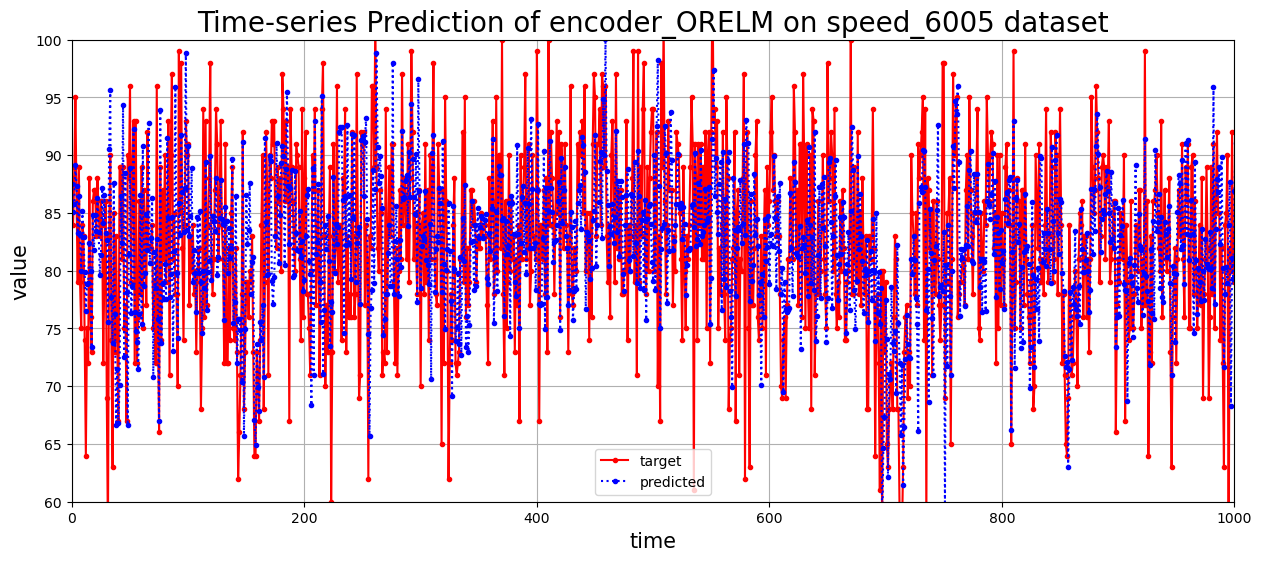

Prediction plot is saved to./predictionPlot.png


In [36]:
algorithm = config.job_type
plt.figure(figsize=(15,6))
targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
plt.xlim([0,1000])
plt.ylim([60, 100])
plt.ylabel('value',fontsize=15)
plt.xlabel('time',fontsize=15)
plt.ion()
plt.grid()
plt.legend(handles=[targetPlot, predictedPlot])
plt.title('Time-series Prediction of '+algorithm+' on '+dataSet+' dataset',fontsize=20,fontweight=40)
plot_path = './predictionPlot.png'
#plt.savefig(plot_path,plot_pathbbox_inches='tight')
plt.savefig(plot_path,bbox_inches='tight')
plt.draw()
plt.show()
plt.pause(0)
print('Prediction plot is saved to'+plot_path)